In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=948feac33089e85c4140944a29a42696edba81d34b4909428661e88a37db4e51
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
import pyspark
import pyspark.sql as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions as pyspark_functions
from pyspark import SparkContext, SparkConf

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

#그룹화

데이터 그룹 기반의 집계는 단일 컬럼의 데이터를 그룹화하고 해당 그룹의 다른 여러 컬럼을 사용해서 계산하기 위해 카테고리형 데이터를 사용.



In [4]:
df = spark.read.option("inferSchema","true").option("header","true").csv("/content/sample_data/california_housing_test.csv")

In [5]:
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0|      11.0|       6.1359|          330000.0|
|  -119.67|   36.33|              19.0|     1241.0|         244.0|     850.0|     237.0|       2.9375|           81700.0|
|  -119.56|   36.51|    

longitude 컬럼과 latitude 컬럼의 그룹화 하여 집계(count)를 해봅니다.

In [6]:
df.groupBy("longitude","latitude").count().show()

+---------+--------+-----+
|longitude|latitude|count|
+---------+--------+-----+
|  -122.05|   37.36|    1|
|  -118.27|   33.94|    4|
|   -118.4|    34.0|    1|
|   -119.7|   34.42|    1|
|  -122.36|   37.93|    1|
|  -117.69|    33.6|    1|
|  -117.27|   33.15|    1|
|  -120.98|   38.66|    1|
|   -119.8|   36.86|    1|
|  -121.69|   38.16|    1|
|  -117.26|   33.26|    1|
|  -117.68|   35.62|    1|
|  -120.96|   38.66|    1|
|  -122.35|   37.97|    1|
|  -121.97|   37.97|    1|
|  -118.26|   33.95|    3|
|  -117.24|   33.18|    1|
|  -122.27|   41.23|    1|
|  -117.53|   33.97|    1|
|  -120.89|   37.48|    1|
+---------+--------+-----+
only showing top 20 rows



#표현식을 이용한 그룹화

매서드 보다 count 함수를 사용하길 추천.

count 함수를 select 구문에 표현식으로 지정하는 것보다 agg 메서드를 사용하는 것이 좋다.

##why?
1. 데이터프레임에 대한 집계 연산을 수행하겠다는 의도를 명확하게 표현합니다. 이는 코드를 읽는 사람에게 데이터 처리의 의도를 더 명확하게 전달할 수 있습니다. (코드의 가독성)
2. 복잡한 집계 지원: agg 메서드는 여러 집계 함수를 동시에 사용할 수 있게 해줍니다. 이는 다양한 집계 연산을 한 번에 수행하고자 할 때 매우 유용합니다. 예를 들어, 평균, 최대값, 최소값 등을 한 번에 계산할 수 있습니다.
3. 성능 최적화: 내부적으로, Spark는 agg 메서드를 사용할 때 집계 연산에 최적화된 방식으로 실행 계획을 구성할 수 있습니다. 이는 큰 데이터셋을 처리할 때 성능 향상을 가져올 수 있습니다.


In [7]:
from pyspark.sql.functions import count, expr

In [8]:
df.groupBy("longitude").agg(count("latitude").alias("housing_median_age"),expr("count(latitude)")).show()

+---------+------------------+---------------+
|longitude|housing_median_age|count(latitude)|
+---------+------------------+---------------+
|  -121.27|                 5|              5|
|  -119.04|                 1|              1|
|  -122.02|                10|             10|
|  -121.22|                 2|              2|
|  -122.68|                 2|              2|
|  -120.88|                 2|              2|
|   -120.3|                 1|              1|
|  -117.94|                17|             17|
|  -116.99|                 3|              3|
|  -120.73|                 2|              2|
|  -117.17|                 5|              5|
|  -115.59|                 1|              1|
|  -116.83|                 1|              1|
|   -121.6|                 1|              1|
|   -122.6|                 1|              1|
|  -117.11|                 7|              7|
|  -116.85|                 2|              2|
|  -117.44|                 2|              2|
|  -120.07|  

#맵을 이용한 그룹화

stddev_pop : 표준편차

In [9]:
df.groupBy("longitude").agg(expr("avg(housing_median_age)"), expr("stddev_pop(population)")).show()

+---------+-----------------------+----------------------+
|longitude|avg(housing_median_age)|stddev_pop(population)|
+---------+-----------------------+----------------------+
|  -121.27|                   22.4|     889.6873608183945|
|  -119.04|                   11.0|                   0.0|
|  -122.02|                   28.5|     645.2931426878795|
|  -121.22|                   27.0|                 340.5|
|  -122.68|                   35.0|                 332.0|
|  -120.88|                   16.5|                 523.0|
|   -120.3|                   17.0|                   0.0|
|  -117.94|     29.294117647058822|     617.6406498266925|
|  -116.99|     16.333333333333332|    501.38208982770817|
|  -120.73|                   27.0|                 197.5|
|  -117.17|                   24.2|     377.7747477002665|
|  -115.59|                   17.0|                   0.0|
|  -116.83|                   18.0|                   0.0|
|   -121.6|                    5.0|                   0.

#윈도우 함수

표준 group-by 함수를 사용하면 모든 로우 레코드가 단일 그룹으로만 이동.
윈도우 함수는 프레임에 입력되는 모든 로우에 대해 결괏값을 계산.

프레임은 로우 그룹 기반의 테이블을 의미.
각 로우는 하나 이상의 프레임에 할당될 수 있음.



In [10]:
df2 = spark.read.option("header","true").option("encoding", "CP949").csv("/content/KT내국인 생활이동 데이터.csv")

In [11]:
df2.show()

+----------------------+-------------------+----------------------------+---------------------+------------------+---------------------------+--------------+---------------+------------+--------------+-------------------+-------------------+--------------+----------------+----------------+
|출발_년월일(DEPRT_YMD)|출발_시(DEPRT_HOUR)|출발_20분_단위(DEPRT_MINUTE)|도착_년월일(DEST_YMD)|도착_시(DEST_HOUR)|도착_20분_단위(DEST_MINUTE)|출발지(DEPRTR)|도착지(DESTNTN)|성별(GENDER)|연령대(AGE_GR)|이동유형(FLOW_TYPE)|소요시간(TRVL_TIME)|이동거리(DIST)|인원(LIFE_FLPOP)|기준년월(YYYYMM)|
+----------------------+-------------------+----------------------------+---------------------+------------------+---------------------------+--------------+---------------+------------+--------------+-------------------+-------------------+--------------+----------------+----------------+
|              20200505|                 00|                          00|             20200505|                23|                         40|        111743|         111494|         

In [12]:
from pyspark.sql.functions import col, to_date

In [13]:
dfWithDate=df2.withColumn("date", to_date(col("출발_년월일(DEPRT_YMD)"), "yyyy/mm/dd"))
dfWithDate.createOrReplaceTempView("dfWithDate")

In [14]:
dfWithDate.show()

+----------------------+-------------------+----------------------------+---------------------+------------------+---------------------------+--------------+---------------+------------+--------------+-------------------+-------------------+--------------+----------------+----------------+----+
|출발_년월일(DEPRT_YMD)|출발_시(DEPRT_HOUR)|출발_20분_단위(DEPRT_MINUTE)|도착_년월일(DEST_YMD)|도착_시(DEST_HOUR)|도착_20분_단위(DEST_MINUTE)|출발지(DEPRTR)|도착지(DESTNTN)|성별(GENDER)|연령대(AGE_GR)|이동유형(FLOW_TYPE)|소요시간(TRVL_TIME)|이동거리(DIST)|인원(LIFE_FLPOP)|기준년월(YYYYMM)|date|
+----------------------+-------------------+----------------------------+---------------------+------------------+---------------------------+--------------+---------------+------------+--------------+-------------------+-------------------+--------------+----------------+----------------+----+
|              20200505|                 00|                          00|             20200505|                23|                         40|        111743|         1

In [15]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc

windowSpec = Window.partitionBy("이동거리(DIST)","출발_년월일(DEPRT_YMD)")\
    .orderBy(desc("출발_시(DEPRT_HOUR)"))\
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

집계함수를 사용해 고객의 시간대별 최대 구매 개수를 구하는 예시

In [16]:
from pyspark.sql.functions import max

maxPurchaseQuantity = max(col("출발_시(DEPRT_HOUR)")).over(windowSpec)

dense_rank 함수를 사용해 모든 고객에 대해 최대 구매 수량을 가진 날짜가 언제인지 알아보자

In [17]:
from pyspark.sql.functions import dense_rank, rank

purchaseDenseRank = dense_rank().over(windowSpec)
purchaseRank = rank().over(windowSpec)

select 메서드를 사용해 계산된 윈도우 값을 확인해보자

In [18]:
from pyspark.sql.functions import col

dfWithDate.orderBy("출발_년월일(DEPRT_YMD)")\
    .select(
        col("출발_년월일(DEPRT_YMD)"),
        col("이동거리(DIST)"),
        purchaseRank.alias("quantityRank"),
        purchaseDenseRank.alias("quantityDenseRank"),
        maxPurchaseQuantity.alias("maxPurchaseQuantity")
    ).show()

+----------------------+--------------+------------+-----------------+-------------------+
|출발_년월일(DEPRT_YMD)|이동거리(DIST)|quantityRank|quantityDenseRank|maxPurchaseQuantity|
+----------------------+--------------+------------+-----------------+-------------------+
|              20210712|          1002|           1|                1|                 00|
|              20200205|         10023|           1|                1|                 13|
|              20200806|         10089|           1|                1|                 00|
|              20210128|         10101|           1|                1|                 16|
|              20210728|         10121|           1|                1|                 10|
|              20210106|         10149|           1|                1|                 14|
|              20210118|          1015|           1|                1|                 16|
|              20200527|        102764|           1|                1|                 09|
|       

#롤업

롤업은 group-by 그타일의 다양한 연산을 수행할 수 있는 다차원 집계 기능.





In [20]:
from pyspark.sql import functions as F

rolledUpDF = df.rollup("longitude", "housing_median_age")\
    .agg(F.sum("population").alias("total_population"))\
    .select("longitude", "housing_median_age", "total_population")\
    .orderBy("longitude")

rolledUpDF.show()

+---------+------------------+----------------+
|longitude|housing_median_age|total_population|
+---------+------------------+----------------+
|     NULL|              NULL|       4208396.0|
|  -124.18|              NULL|           788.0|
|  -124.18|              40.0|           788.0|
|  -124.17|              NULL|          1259.0|
|  -124.17|              16.0|          1259.0|
|  -124.16|              19.0|           841.0|
|  -124.16|              46.0|          1206.0|
|  -124.16|              35.0|          1053.0|
|  -124.16|              NULL|          4008.0|
|  -124.16|              52.0|           908.0|
|  -124.15|              41.0|           911.0|
|  -124.15|              NULL|           911.0|
|  -124.14|              27.0|           521.0|
|  -124.14|              18.0|          1375.0|
|  -124.14|              NULL|          2768.0|
|  -124.14|              32.0|           872.0|
|   -124.1|              17.0|           823.0|
|   -124.1|              NULL|          

Null 값을 가진 로우에서 전체 날짜의 합계를 확인할 수 있고

롤업된 두 개의 컬럼값이 모두 null인 로우는 두 컬럼에 속한 레코드의
전체 합계를 나타냄

In [21]:
rolledUpDF.where("longitude IS NULL").show()

rolledUpDF.where("housing_median_age IS NULL").show()

+---------+------------------+----------------+
|longitude|housing_median_age|total_population|
+---------+------------------+----------------+
|     NULL|              NULL|       4208396.0|
+---------+------------------+----------------+

+---------+------------------+----------------+
|longitude|housing_median_age|total_population|
+---------+------------------+----------------+
|     NULL|              NULL|       4208396.0|
|  -124.18|              NULL|           788.0|
|  -124.17|              NULL|          1259.0|
|  -124.16|              NULL|          4008.0|
|  -124.15|              NULL|           911.0|
|  -124.14|              NULL|          2768.0|
|   -124.1|              NULL|           823.0|
|  -124.09|              NULL|          2618.0|
|  -124.01|              NULL|           943.0|
|  -123.92|              NULL|          1382.0|
|  -123.85|              NULL|          2095.0|
|   -123.8|              NULL|          1452.0|
|  -123.79|              NULL|         

#큐브

큐브는 롤업을 고차원적으로 사용할 수 있게 해준다.
요소들을 계층적으로 다루는 대신 모든 차원에 동일한 작업을 수행.

모든 정보를 빠르고 쉽게 조회할 수 있는 요약 정보 테이블을 만들 수 있음.

In [22]:
from pyspark.sql.functions import sum, col

df.cube("longitude", "housing_median_age").agg(sum(col("population")))\
    .select("longitude", "housing_median_age", "sum(population)").orderBy("longitude").show()

+---------+------------------+---------------+
|longitude|housing_median_age|sum(population)|
+---------+------------------+---------------+
|     NULL|              26.0|       114850.0|
|     NULL|              33.0|       115735.0|
|     NULL|              29.0|       108569.0|
|     NULL|              36.0|       128451.0|
|     NULL|              51.0|         9146.0|
|     NULL|              37.0|        92411.0|
|     NULL|              44.0|        57269.0|
|     NULL|              39.0|        66303.0|
|     NULL|              47.0|        29139.0|
|     NULL|               9.0|        49206.0|
|     NULL|              41.0|        54520.0|
|     NULL|              35.0|       142089.0|
|     NULL|              10.0|        45942.0|
|     NULL|              24.0|       113818.0|
|     NULL|              14.0|        91228.0|
|     NULL|              21.0|       100844.0|
|     NULL|               3.0|        32431.0|
|     NULL|               2.0|        18405.0|
|     NULL|  

#피벗

피벗을 사용해 로우를 컬럼으로 변환할 수 있음.

In [23]:
pivoted = df.groupBy("longitude").pivot("housing_median_age").sum()

In [24]:
pivoted.show()

+---------+------------------+-----------------+---------------------------+--------------------+-----------------------+-------------------+-------------------+----------------------+---------------------------+------------------+-----------------+---------------------------+--------------------+-----------------------+-------------------+-------------------+----------------------+---------------------------+------------------+-----------------+---------------------------+--------------------+-----------------------+-------------------+-------------------+----------------------+---------------------------+------------------+-----------------+---------------------------+--------------------+-----------------------+-------------------+-------------------+----------------------+---------------------------+------------------+-----------------+---------------------------+--------------------+-----------------------+-------------------+-------------------+----------------------+------------

#조인

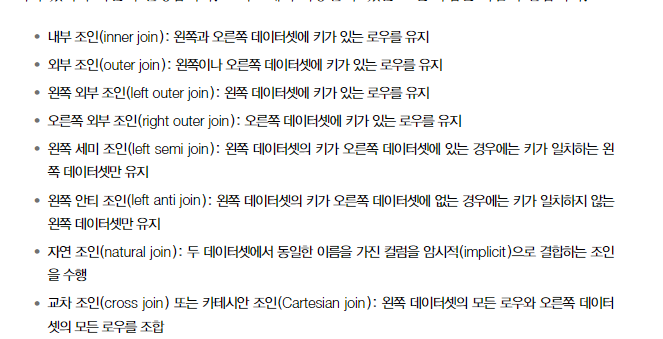

In [27]:
#데이터셋
person = spark.createDataFrame([
    (0, "Bill Chambers", "0", [100]),
    (1, "Metei Zaharia", "1", [500,250,100]),
    (2, "Michael Armbrust", "1", [250,100]),
]).toDF("id", "name", "graduate_program", "spark_status")

graduateProgram = spark.createDataFrame([
    (0, "Masters", "School of Information", "UC Berkeley"),
    (2, "Masters", "EECS", "UC Berkeley"),
    (1, "Ph.D.", "EECS", "UC Berkeley"),
]).toDF("id", "degree", "department", "school")

sparkStatus = spark.createDataFrame([
    (500, "Vice President"),
    (250, "PMC Member"),
    (100, "Contributor"),
]).toDF("id", "status")


In [28]:
#테이블로 등록
person.createOrReplaceTempView("person")
graduateProgram.createOrReplaceTempView("graduateProgram")
sparkStatus.createOrReplaceTempView("sparkStatus")


In [29]:
#내부 조인
joinExpression = person["graduate_program"] == graduateProgram["id"]

In [30]:
#비어있는 데이터 프레임을 얻게됨
wrongJoinExpression = person["name"] == graduateProgram["school"]

In [31]:
person.join(graduateProgram, joinExpression).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Metei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [33]:
#조인 타입지정
joinType = "inner"

person.join(graduateProgram, joinExpression, joinType).show()

+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
| id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|  1|   Metei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|  2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
+---+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [34]:
#외부 조인
joinType = "outer"

person.join(graduateProgram, joinExpression, joinType).show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|   1|   Metei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|NULL|            NULL|            NULL|           NULL|  2|Masters|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [35]:
#왼쪽 외부 조인
joinType = "left_outer"

graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
| id| degree|          department|     school|  id|            name|graduate_program|   spark_status|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+
|  0|Masters|School of Informa...|UC Berkeley|   0|   Bill Chambers|               0|          [100]|
|  1|  Ph.D.|                EECS|UC Berkeley|   2|Michael Armbrust|               1|     [250, 100]|
|  1|  Ph.D.|                EECS|UC Berkeley|   1|   Metei Zaharia|               1|[500, 250, 100]|
|  2|Masters|                EECS|UC Berkeley|NULL|            NULL|            NULL|           NULL|
+---+-------+--------------------+-----------+----+----------------+----------------+---------------+



In [36]:
#오른쪽 외부 조인
joinType = "right_outer"

person.join(graduateProgram, joinExpression, joinType).show()

+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|  id|            name|graduate_program|   spark_status| id| degree|          department|     school|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+
|   0|   Bill Chambers|               0|          [100]|  0|Masters|School of Informa...|UC Berkeley|
|   2|Michael Armbrust|               1|     [250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|   1|   Metei Zaharia|               1|[500, 250, 100]|  1|  Ph.D.|                EECS|UC Berkeley|
|NULL|            NULL|            NULL|           NULL|  2|Masters|                EECS|UC Berkeley|
+----+----------------+----------------+---------------+---+-------+--------------------+-----------+



In [37]:
#왼쪽 세미 조인
joinType = "left_semi"

graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------+
| id| degree|          department|     school|
+---+-------+--------------------+-----------+
|  0|Masters|School of Informa...|UC Berkeley|
|  1|  Ph.D.|                EECS|UC Berkeley|
+---+-------+--------------------+-----------+



In [38]:
gradProgram2 = graduateProgram.union(spark.createDataFrame([
    (0, "Masters", "Duplicated Row", "Duplicated School")
]))

gradProgram2.createOrReplaceTempView("gradProgram2")

In [39]:
gradProgram2.join(person, joinExpression, joinType).show()

+---+-------+--------------------+-----------------+
| id| degree|          department|           school|
+---+-------+--------------------+-----------------+
|  0|Masters|School of Informa...|      UC Berkeley|
|  1|  Ph.D.|                EECS|      UC Berkeley|
|  0|Masters|      Duplicated Row|Duplicated School|
+---+-------+--------------------+-----------------+



##복합 데이터 타입의 조인

In [40]:
from pyspark.sql.functions import expr

person.withColumnRenamed("id", "personID")\
    .join(sparkStatus, expr("array_contains(spark_status, id)")).show()

+--------+----------------+----------------+---------------+---+--------------+
|personID|            name|graduate_program|   spark_status| id|        status|
+--------+----------------+----------------+---------------+---+--------------+
|       0|   Bill Chambers|               0|          [100]|100|   Contributor|
|       1|   Metei Zaharia|               1|[500, 250, 100]|500|Vice President|
|       1|   Metei Zaharia|               1|[500, 250, 100]|250|    PMC Member|
|       1|   Metei Zaharia|               1|[500, 250, 100]|100|   Contributor|
|       2|Michael Armbrust|               1|     [250, 100]|250|    PMC Member|
|       2|Michael Armbrust|               1|     [250, 100]|100|   Contributor|
+--------+----------------+----------------+---------------+---+--------------+



#중복 컬럼명 처리

조인을 수행할 때 가장 까다로운 것 중 하나는 중복된 컬럼명을 다루는 것이다.

해결 방법1 ; 불리언 형태의 조인 표현식을 문자열이나 시퀀스 형태로 바꾸고 조인하면 하나가 자동으로 제거가 된다. (가장 간단한 방법)

해결 방법2 : 조인 후 컬럼 제거 단 조인 시 동일한 키 이름을 사용하거나 원본 DF에
동일한 컬럼명이 존재해야 한다.

하결 방법3 : 조인 전 컬럼명 변경
